#### REF
* https://github.com/dmlc/gluon-nlp/blob/master/docs/api/notes/data_api.rst

## Data Loading

In [1]:
import os
import pandas as pd
import numpy as np
import collections
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, auc
from mxnet import gluon


import time, re
import multiprocessing as mp
import itertools
from tqdm import tqdm, tqdm_notebook
import mxnet as mx
import spacy
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'

In [2]:
MAX_SENTENCE_LENGTH = 20
MAX_VOCAB = 10000

### Preprocessing using Spacy

In [3]:
nlp = spacy.load("en")

word_freq = collections.Counter()
max_len = 0
num_rec = 0
print('Count words and build vocab...')
with open('../data/umich-sentiment-train.txt', 'rb') as f:
    for line in f:
        _lab, _sen = line.decode('utf8').strip().split('\t')
        words = [token.lemma_ for token in nlp(_sen) if token.is_alpha] # Stop word제거 안한 상태 
        # 제거를 위해 [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
        if len(words) > max_len:
            max_len = len(words)
        for word in words:
            word_freq[word] += 1
        num_rec += 1

# most_common output -> list
word2idx = {x[0]: i+2 for i, x in enumerate(word_freq.most_common(MAX_VOCAB - 2))}
word2idx ['PAD'] = 0
word2idx['UNK'] = 1

idx2word= {i:v for v, i in word2idx.items()}
vocab_size = len(word2idx)

print('Prepare data...')
y = []
x = []
origin_txt = []
with open('../data/umich-sentiment-train.txt', 'rb') as f:
    for line in f:
        _label, _sen = line.decode('utf8').strip().split('\t')
        origin_txt.append(_sen)
        y.append(int(_label))
        words = [token.lemma_ for token in nlp(_sen) if token.is_alpha] # Stop word제거 안한 상태
        words = [x for x in words if x != '-PRON-'] # '-PRON-' 제거
        _seq = []
        for word in words:
            if word in word2idx.keys():
                _seq.append(word2idx[word])
            else:
                _seq.append(word2idx['UNK'])
        if len(_seq) < MAX_SENTENCE_LENGTH:
            _seq.extend([0] * ((MAX_SENTENCE_LENGTH) - len(_seq)))
        else:
            _seq = _seq[:MAX_SENTENCE_LENGTH]
        x.append(_seq)

pd.DataFrame(y, columns = ['yn']).reset_index().groupby('yn').count().reset_index()

Count words and build vocab...
Prepare data...


yn  index
0   0   3091
1   1   3995

In [4]:
## Data process - tr/va split and define iterator

tr_idx = np.random.choice(range(len(x)), int(len(x) * .8))
va_idx = [x for x in range(len(x)) if x not in tr_idx]

tr_x = [x[i] for i in tr_idx]
tr_y = [y[i] for i in tr_idx]
tr_origin = [origin_txt[i] for i in tr_idx]

va_x = [x[i] for i in va_idx]
va_y = [y[i] for i in va_idx]
va_origin = [origin_txt[i] for i in va_idx]

batch_size = 16

learning_rate = .0002
log_interval = 100


train_data = mx.io.NDArrayIter(data=[tr_x, tr_y], batch_size=batch_size, shuffle = False, last_batch_handle = 'discard')
valid_data = mx.io.NDArrayIter(data=[va_x, va_y], batch_size=batch_size, shuffle = False, last_batch_handle = 'discard')

In [5]:
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn, rnn
from mxnet.ndarray.linalg import gemm2
import mxnet as mx
context = mx.gpu()

#### Sentence Representation

In [65]:
class Sentence_Representation(nn.Block):
    def __init__(self, **kwargs):
        super(Sentence_Representation, self).__init__()
        for (k, v) in kwargs.items():
            setattr(self, k, v)
        
        with self.name_scope():
            self.embed = nn.Embedding(self.vocab_size, self.emb_dim)
            self.g_fc1 = nn.Dense(self.hidden_dim,activation='relu')
            self.g_fc2 = nn.Dense(self.hidden_dim,activation='relu')
            self.attn = nn.Dense(1, activation = 'tanh')
            
    def forward(self, x):
        embeds = self.embed(x) # batch * time step * embedding
        x_i = embeds.expand_dims(1)
        x_i = nd.repeat(x_i,repeats= self.sentence_length, axis=1)
        x_j = embeds.expand_dims(2)
        x_j = nd.repeat(x_j,repeats= self.sentence_length, axis=2)
        x_full = nd.concat(x_i,x_j,dim=3) # batch * time step * time step * (2 * embedding)
        # New input data
        _x = x_full.reshape((-1, 2 * self.emb_dim))
        # Network for attention
        _attn = self.attn(_x)
        _att = _attn.reshape((-1, self.sentence_length, self.sentence_length))
        _att = nd.sigmoid(_att)
        att = nd.softmax(_att, axis = 1)
        _x = self.g_fc1(_x) # (batch * time step * time step) * hidden_dim
        _x = self.g_fc2(_x) # (batch * time step * time step) * hidden_dim
        # sentence_length*sentence_length개의 결과값을 모두 합해서 sentence representation으로 나타냄
        x_g = _x.reshape((-1, self.sentence_length, self.sentence_length, self.hidden_dim))
    
        _inflated_att = _att.expand_dims(axis = -1)
        _inflated_att = nd.repeat(_inflated_att, repeats = self.hidden_dim, axis = 3)

        x_q = nd.multiply(_inflated_att, x_g)

        sentence_rep = nd.mean(x_q.reshape(shape = (-1, self.sentence_length **2, self.hidden_dim)), axis= 1)
        return sentence_rep, att

#### Classifier

In [66]:
classifier = nn.Sequential()
classifier.add(nn.Dense(16, activation = 'relu'))
classifier.add(nn.Dense(8, activation = 'relu'))
classifier.add(nn.Dense(1))
classifier.collect_params().initialize(mx.init.Xavier(), ctx = context)

#### Sentiment analysis classifier

In [67]:
class SA_Classifier(nn.Block):
    def __init__(self, sen_rep, classifier, context, **kwargs):
        super(SA_Classifier, self).__init__(**kwargs)
        self.context = context
        with self.name_scope():
            self.sen_rep = sen_rep
            self.classifier = classifier
            
    def forward(self, x):
        # Initial hidden state
        # sentence representation할 때 hidden의 context가 cpu여서 오류 발생. context를 gpu로 전환
        x, att = self.sen_rep(x)
        x = nd.flatten(x)
        res = self.classifier(x)
        return res, att       

#### Initiate sentiment classifier

In [68]:
emb_dim = 10 # Emb dim
hidden_dim = 30 # Hidden dim for LSTM

param = {'emb_dim': emb_dim, 'hidden_dim': hidden_dim, 'vocab_size': vocab_size, 'sentence_length': MAX_SENTENCE_LENGTH, 'dropout': .2}
sen_rep = Sentence_Representation(**param)
sen_rep.collect_params().initialize(mx.init.Xavier(), ctx = context)

In [69]:
sa = SA_Classifier(sen_rep, classifier, context)
loss = gluon.loss.SigmoidBCELoss()
trainer = gluon.Trainer(sa.collect_params(), 'adam', {'learning_rate': 1e-3})
sa.hybridize()

/opt/venv/lib/python3.6/site-packages/mxnet/gluon/nn/basic_layers.py:83: UserWarning: All children of this Sequential layer are HybridBlocks. Consider using HybridSequential for the best performance.
  warnings.warn('All children of this Sequential layer are HybridBlocks. Consider ' \


In [70]:
def evaluate(net, dataIterator, context):
    dataIterator.reset()
    loss = gluon.loss.SigmoidBCELoss()
    total_L = 0.0
    total_sample_num = 0
    total_correct_num = 0
    start_log_interval_time = time.time()
    for i, batch in enumerate(dataIterator):
        data =  batch.data[0].as_in_context(context)
        label = batch.data[1].as_in_context(context)
        output, _ = net(data)
        L = loss(output, label)
        pred = (output > 0.5).reshape((-1,))
        total_L += L.sum().asscalar()
        total_sample_num += len(label)
        total_correct_num += (pred == label).sum().asscalar()
        if (i + 1) % log_interval == 0:
            print('[Batch {}/{}] elapsed {:.2f} s'.format(
                i + 1, dataIterator.num_data//dataIterator.batch_size,
                time.time() - start_log_interval_time))
            start_log_interval_time = time.time()
    avg_L = total_L / float(total_sample_num)
    acc = total_correct_num / float(total_sample_num)
    return avg_L, acc

In [71]:
n_epoch = 5
for epoch in tqdm_notebook(range(n_epoch), desc = 'epoch'):
    ## Training
    train_data.reset()
    # Epoch training stats
    start_epoch_time = time.time()
    epoch_L = 0.0
    epoch_sent_num = 0
    epoch_wc = 0
    # Log interval training stats
    start_log_interval_time = time.time()
    log_interval_wc = 0
    log_interval_sent_num = 0
    log_interval_L = 0.0
    
    for i, batch in enumerate(train_data):
        _data = batch.data[0].as_in_context(context)
        _label = batch.data[1].as_in_context(context)
        L = 0
        wc = len(_data)
        log_interval_wc += wc
        epoch_wc += wc
        log_interval_sent_num += _data.shape[1]
        epoch_sent_num += _data.shape[1]
        with autograd.record():
            _out, _ = sa(_data)
            L = L + loss(_out, _label).mean().as_in_context(context)
        L.backward()
        trainer.step(_data.shape[0])
        log_interval_L += L.asscalar()
        epoch_L += L.asscalar()
        if (i + 1) % log_interval == 0:
            tqdm.write('[Epoch {} Batch {}/{}] elapsed {:.2f} s, \
                    avg loss {:.6f}, throughput {:.2f}K wps'.format(
                    epoch, i + 1, train_data.num_data//train_data.batch_size,
                    time.time() - start_log_interval_time,
                    log_interval_L / log_interval_sent_num,
                    log_interval_wc / 1000 / (time.time() - start_log_interval_time)))
            # Clear log interval training stats
            start_log_interval_time = time.time()
            log_interval_wc = 0
            log_interval_sent_num = 0
            log_interval_L = 0
    end_epoch_time = time.time()
    test_avg_L, test_acc = evaluate(sa, valid_data, context)
    tqdm.write('[Epoch {}] train avg loss {:.6f}, valid acc {:.2f}, \
        valid avg loss {:.6f}, throughput {:.2f}K wps'.format(
        epoch, epoch_L / epoch_sent_num,
        test_acc, test_avg_L, epoch_wc / 1000 /
        (end_epoch_time - start_epoch_time)))

[Epoch 0 Batch 100/354] elapsed 0.76 s,                     avg loss 0.034267, throughput 2.11K wps
[Epoch 0 Batch 200/354] elapsed 0.71 s,                     avg loss 0.020813, throughput 2.25K wps
[Epoch 0 Batch 300/354] elapsed 0.71 s,                     avg loss 0.005735, throughput 2.24K wps
[Batch 100/199] elapsed 0.30 s
[Epoch 0] train avg loss 0.017533, valid acc 0.98,         valid avg loss 0.057823, throughput 2.21K wps
[Epoch 1 Batch 100/354] elapsed 0.71 s,                     avg loss 0.001443, throughput 2.25K wps
[Epoch 1 Batch 200/354] elapsed 0.71 s,                     avg loss 0.001423, throughput 2.24K wps
[Epoch 1 Batch 300/354] elapsed 0.71 s,                     avg loss 0.001386, throughput 2.24K wps
[Batch 100/199] elapsed 0.30 s
[Epoch 1] train avg loss 0.001295, valid acc 0.98,         valid avg loss 0.045285, throughput 2.25K wps
[Epoch 2 Batch 100/354] elapsed 0.71 s,                     avg loss 0.000348, throughput 2.25K wps
[Epoch 2 Batch 200/354] elap

### Prediction

In [72]:
def get_pred(net, iterator):
    pred_sa = []
    label_sa = []
    va_text = []
    iterator.reset()
    for i, batch in enumerate(iterator):
        if i % 100 == 0:
            print('i = {}'.format(i))
        data =  batch.data[0].as_in_context(context)
        label = batch.data[1].as_in_context(context)
        output, _ = net(data)
        L = loss(output, label)
        pred = (nd.sigmoid(output) > 0.5).reshape((-1,))
        pred_sa.extend(pred.asnumpy())
        label_sa.extend(label.asnumpy())
        va_text.extend([' '.join([idx2word[np.int(x)] for x in y.asnumpy() if idx2word[np.int(x)] is not 'PAD']) for y in data])
    pred_sa_pd = pd.DataFrame(pred_sa, columns  = ['pred_sa'])
    label_pd = pd.DataFrame(label_sa, columns = ['label'])
    text_pd = pd.DataFrame(va_text, columns = ['text'])
    res = pd.concat([text_pd, pred_sa_pd, label_pd], axis = 1)
    return res

## Classification results

In [73]:
result = get_pred(sa, valid_data)

i = 0
i = 100


In [74]:
result[result.pred_sa != result.label].shape

(41, 3)

In [75]:
result[result.pred_sa != result.label].head(10)

text  pred_sa  label
19   personally neither hate nor love the da vinci ...      0.0    1.0
42                 oh oh oh and love the da vinci code      0.0    1.0
65   agree with love da vinci code just think ridic...      0.0    1.0
424  friday i stay in watch mission impossible whic...      0.0    1.0
452  love the mission impossible movie but this guy...      0.0    1.0
459  mission impossible kick ass mission impossible...      0.0    1.0
490  mission impossible be pretty cool though want ...      0.0    1.0
504  mission impossible do kick ass and yes jessica...      0.0    1.0
509  like mission impossible but hate tom cruise ge...      0.0    1.0
519  think mission impossible think bond girl think...      0.0    1.0

In [85]:
result[result.pred_sa != result.label]['text'].iloc[8]

'like mission impossible but hate tom cruise get that straight update day in a row like magic and shit'

In [155]:
def plot_attention(net, n_samples = 10, mean = False):
    from matplotlib import pyplot as plt
    import seaborn as sns
    sns.set()
    idx = np.random.choice(np.arange(len(va_x)), size = n_samples, replace = False)
    _dat = [va_x[i] for i in idx]
    
    w_idx = []
    word = [[idx2word[x] for x in y] for y in _dat]
    original_txt = [va_origin[i] for i in idx]
    out, att = net(nd.array(_dat, ctx = context)) 

    _a = []
    _w = []
    for x, y, z in zip(word, att, original_txt):
        _idx = [i for i, _x in enumerate(x) if _x is not 'PAD']
        _w.append(np.array([x[i] for i in _idx]))
        _y = y[:, _idx]
        _a.append(np.array([_y[i].asnumpy() for i in _idx]))
        
    _label = [va_y[i] for i in idx]
    _pred = (nd.sigmoid(out) > .5).asnumpy()
    
    fig, axes = plt.subplots(np.int(np.ceil(n_samples / 3)), 3, sharex = False, sharey = False)
    plt.subplots_adjust(hspace=1)

    fig.set_size_inches(20, 20)
    plt.subplots_adjust(hspace=1)

    for i in range(n_samples):
        sns.heatmap(pd.DataFrame(_a[i], index = _w[i], columns = _w[i]).T, ax = axes.flat[i], cmap = 'RdYlGn', linewidths = .3)
        axes.flat[i].set_title('Label: {}, Pred: {}'.format(_label[i], np.int(_pred[i])))
    pass

In [ ]:
plot_attention(sa, n_samples = 12, mean = False)

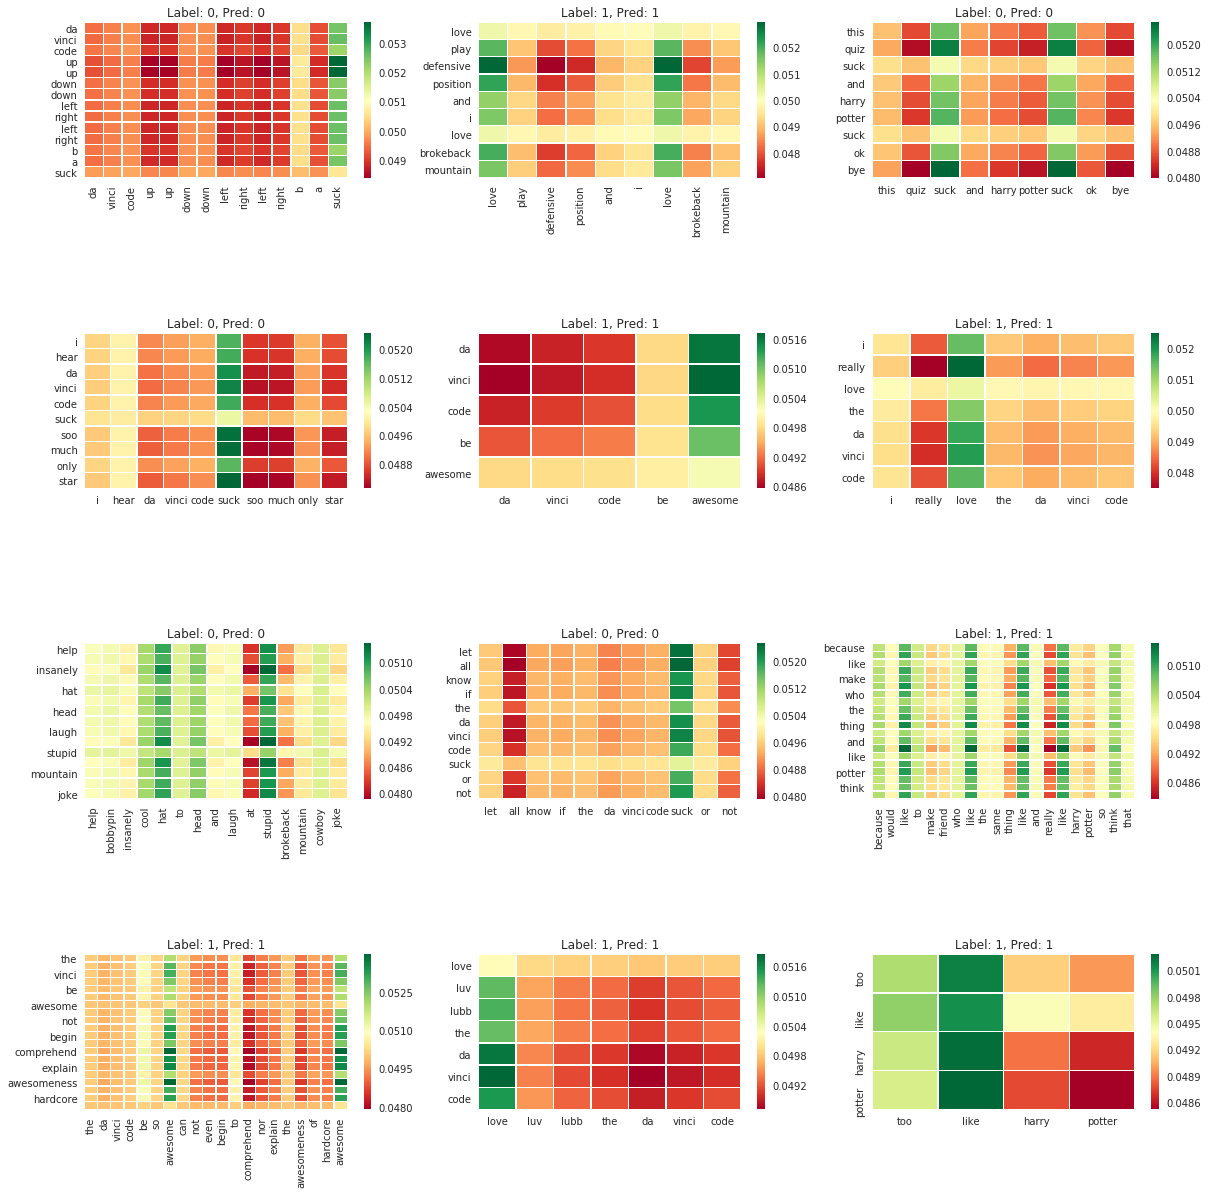

In [157]:
plot_attention(sa, n_samples = 12, mean = False)